<a href="https://colab.research.google.com/github/ckohcm/Projects/blob/main/Topic_Modeling_Steam_Reviews_04_262021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Introduction

The purpose of this research is to understand what the players of selected 4X, turn-based strategy games like and dislike about these games (Endless Legend, Battle Tech, Empire of Sin, Age of Wonder: Planet Fall, and Phoenix Point). We'll be running topic modeling on the positive and negative reviews separately to extract topics. In other words, we'll have 2 corpora (positive/negative), and each has 5 documents/game.
We'll then visualize the topics distributions and generate word clouds of the most the top N keywords for each game. 

There's this guy who talks about how gamers use other other games as a point of reference when reviewing a game, and this inspired that...

# 1. Import the reviews and pickle them to store them locally so that it's easier to load the next time.

In [ ]:
# Run this if using Google Colab
from google.colab import drive 
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/Project 1

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Project 1


In [ ]:
pip install steamreviews

In [ ]:
# import steamreviews
import pandas as pd
from datetime import datetime
pd.set_option("max_colwidth", 100)
pd.set_option('display.max_rows', 1000)

In [ ]:
request_params = dict()

In [ ]:
request_params['language'] = "english"

# App ID for Endless Legend
app_id1 = 289130
dict1, query_count = steamreviews.download_reviews_for_app_id(app_id1, chosen_request_params=request_params)

[appID = 289130] expected #reviews = 9859


In [ ]:
# App ID for Battle Tech
app_id2 = 637090
dict2, query_count = steamreviews.download_reviews_for_app_id(app_id2, chosen_request_params=request_params)

[appID = 637090] expected #reviews = 17968
Number of queries 150 reached. Cooldown: 310 seconds


In [ ]:
# Empire of Sin
app_id3 = 604540
dict3, query_count = steamreviews.download_reviews_for_app_id(app_id3, chosen_request_params=request_params)

[appID = 604540] expected #reviews = 1911


In [ ]:
# Age of Wonder: Planet Fall
app_id4 = 718850
dict4, query_count = steamreviews.download_reviews_for_app_id(app_id4, chosen_request_params=request_params)

[appID = 718850] expected #reviews = 2546


In [ ]:
# Phoenix Point
app_id5 = 839770
dict5, query_count = steamreviews.download_reviews_for_app_id(app_id5, chosen_request_params=request_params)

[appID = 839770] expected #reviews = 1221


In [ ]:
# Stellaris
app_id6 = 281990
dict6, query_count = steamreviews.download_reviews_for_app_id(app_id6, chosen_request_params=request_params)

[appID = 281990] expected #reviews = 58445
Number of queries 150 reached. Cooldown: 310 seconds
Number of queries 150 reached. Cooldown: 310 seconds
Number of queries 150 reached. Cooldown: 310 seconds


### 1.1. Pickle the reviews

In [ ]:
# Going to pickle dump all the dictionaries in case we disconnect
import pickle

In [ ]:
# pkl1_out = open("dict.pickle1", "wb")
# pickle.dump(dict1, pkl1_out)
# pkl1_out.close()

# pkl2_out = open("dict.pickle2", "wb")
# pickle.dump(dict2, pkl2_out)
# pkl2_out.close()

# pkl3_out = open("dict.pickle3", "wb")
# pickle.dump(dict3, pkl3_out)
# pkl3_out.close()

# pkl4_out = open("dict.pickle4", "wb")
# pickle.dump(dict4, pkl4_out)
# pkl4_out.close()

# pkl5_out = open("dict.pickle5", "wb")
# pickle.dump(dict5, pkl5_out)
# pkl5_out.close()

# pkl6_out = open("dict.pickle6", "wb")
# pickle.dump(dict6, pkl6_out)
# pkl6_out.close()

In [ ]:
pkl1_in = open("dict.pickle1", "rb")
dict1 = pickle.load(pkl1_in)

pkl2_in = open("dict.pickle2", "rb")
dict2 = pickle.load(pkl2_in)

pkl3_in = open("dict.pickle3", "rb")
dict3 = pickle.load(pkl3_in)

pkl4_in = open("dict.pickle4", "rb")
dict4 = pickle.load(pkl4_in)

pkl5_in = open("dict.pickle5", "rb")
dict5 = pickle.load(pkl5_in)

pkl6_in = open("dict.pickle6", "rb")
dict6 = pickle.load(pkl6_in)

In [ ]:
# Let's look at the keys of the returned dictionary
print(dict1.keys())
print(dict2.keys())
print(dict3.keys())
print(dict4.keys())
print(dict5.keys())
print(dict6.keys())

dict_keys(['reviews', 'query_summary', 'cursors'])
dict_keys(['reviews', 'query_summary', 'cursors'])
dict_keys(['reviews', 'query_summary', 'cursors'])
dict_keys(['reviews', 'query_summary', 'cursors'])
dict_keys(['reviews', 'query_summary', 'cursors'])
dict_keys(['reviews', 'query_summary', 'cursors'])


# 2. Data Cleaning

### 2.1. Import the game reviews into a dataframe, and split them up by positive or negative reviews. This would yield two sets of data for every game.

In [ ]:
def dict_to_dataframe(game_dict):
    # Only save the values with the key as 'reviews' 
    reviews = game_dict['reviews']
    # Save the reviews in a dataframe
    df = pd.DataFrame(reviews)
    # Save rows with the indices called 'review' and 'voted_up'
    df = df.loc[['review', 'voted_up']].transpose()
    # Split positive and negative reviews into 2 dataframes
    positive = df.loc[df['voted_up'] == True, ['review']]
    negative = df.loc[df['voted_up'] == False, ['review']]
    
    return positive, negative

In [ ]:
pos1, neg1 = dict_to_dataframe(dict1)
pos2, neg2 = dict_to_dataframe(dict2)
pos3, neg3 = dict_to_dataframe(dict3)
pos4, neg4 = dict_to_dataframe(dict4)
pos5, neg5 = dict_to_dataframe(dict5)
pos6, neg6 = dict_to_dataframe(dict6)

### 2.2. Simple preprocessing

In [ ]:
import re
import string
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# Create list of stopwords, and add to the lsit
stop_words = stopwords.words('english')
contractions = pd.read_csv('contractions.csv', header=0)
contract_words = [word.lower() for word in contractions['Contraction']]
stop_words.extend(contract_words)
stop_words.extend(['really', 'game', 'games', 'even', 'like'])#, 'would', 'get', 'also'])
stop_words = set(stop_words)
# Remove punctuations in stopwords
stop_words = [re.sub(pattern="[^\w\s]", repl="", string=word) for word in stop_words]

lemmatizer = WordNetLemmatizer()

In [ ]:
len(stop_words)

311

In [ ]:
def preprocessor_for_phrases(review_df):
    """
    This functions preprocesses the reviews by:
    i. converting the 'review' column to a list;
    ii. making all reviews lowercase;
    iii. removing all "'s", punctuations, "\n", and digits;
    iv. tokenizing each string/review;
    v. and finally, returning a list of lists, where each sublist is a tokenized review 
    """
    documents = review_df['review'].values.tolist()
    
    def simple_preprocessor1(documents):
        for text in documents:
            text = text.lower()
            text = re.sub(pattern = "'s'", repl="", string=text)
            text = re.sub(pattern = "[^\w\s]", repl="", string=text)
            text = re.sub(pattern = "\n", repl = " ", string = text)
            text = re.sub(pattern = "\d+", repl = "", string = text)

            text_tokenized = nltk.word_tokenize(text)
    #         tokenized_nostopwords = [token for token in text_tokenized if token not in stop_words]
            yield text_tokenized

    data = list(simple_preprocessor1(documents))
    
    return data

In [ ]:
data_pos1 = preprocessor_for_phrases(pos1)
data_pos2 = preprocessor_for_phrases(pos2)
data_pos3 = preprocessor_for_phrases(pos3)
data_pos4 = preprocessor_for_phrases(pos4)
data_pos5 = preprocessor_for_phrases(pos5)
data_pos6 = preprocessor_for_phrases(pos6)

data_neg1 = preprocessor_for_phrases(neg1)
data_neg2 = preprocessor_for_phrases(neg2)
data_neg3 = preprocessor_for_phrases(neg3)
data_neg4 = preprocessor_for_phrases(neg4)
data_neg5 = preprocessor_for_phrases(neg5)
data_neg6 = preprocessor_for_phrases(neg6)

### 2.3. Complex Preprocessing

In [ ]:
import gensim

In [ ]:
# Build the bigram and trigram models
# Train on the list of tokenized words that's only been removed of punctuations and digits
def create_phrases(data, min_count, bi_threshold, tri_threshold):
    bigram = gensim.models.Phrases(data, min_count=min_count, threshold=bi_threshold) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data], threshold=tri_threshold) 
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    return bigram_mod, trigram_mod

In [ ]:
def text_processor_with_phrases(documents, bigrammod, trigrammod):
    """
    This functions does the following:
    i. generates the bigram phrases in each reivew;
    ii. generates the trigram phrases in each reivew;
    iii. removes all stopwords;
    iv. lemmatizes all tokens;
    v. drops all tokens with fewer than 3 characters;
    vi. drop all reviews/documents with fewer than 6 tokens
    """
    texts = []
    for text in documents:
        text = bigrammod[text]
        text = trigrammod[bigrammod[text]]
        # Remove stopwords 
        nostopwords = [token for token in text if token not in stop_words]   
        # Lemmatize the remaining tokens
        lemmatized = [lemmatizer.lemmatize(token) for token in nostopwords]
        # Drop tokens if it has 2 or less characters
        clean_tokens = [token for token in lemmatized if len(token) > 2]
        texts.append(clean_tokens)
    
    # Drop document that has fewer than 6 tokens
    texts = [text for text in texts if len(text) > 5]
    return texts



In [ ]:
def text_processor_no_phrases(documents):
    """
    This function does the same preprocessing as the above function,
    except this is to be used on the games with smaller amounts of reviews
    like Empire of Sin, as they don't have sufficient tokens to generate meaningful
    phrases.
    
    That said, this functions does the following:
    i. removes all stopwords;
    ii. lemmatizes all tokens;
    iii. drops all tokens with fewer than 3 characters; "be"
    iv. drop all reviews/documents with fewer than 5 tokens
    """
    texts = []
    for text in documents:
        # Remove stopwords 
        nostopwords = [token for token in text if token not in stop_words]   
        # Lemmatize the remaining tokens
        lemmatized = [lemmatizer.lemmatize(token) for token in nostopwords]
        # Drop tokens if it has 2 or less characters
        clean_tokens = [token for token in lemmatized if len(token) > 2]
        texts.append(clean_tokens)
    
    # Drop document that has fewer than 6 tokens
    texts = [text for text in texts if len(text) > 5]
    return texts



### 2.4. Preprocessing Pipeline for Reviews

In [ ]:
pos1.head()

,review
90787622,
90778890,"This is a truly magical game, so much love and attention went into making it. If you like 4X gam..."
90748740,"It's an extremely fun and engaging game. The AI is kinda silly sometimes, but other than that it..."
90694870,yep
90614694,This game means a lot to me. It isn't a perfect 4X but I love everything about it— the art style...


# 3. Exploratory Data Analysis

In [ ]:
data_pos1

In [ ]:
from collections import Counter
# pip install wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

In [ ]:
cloud_stopwords = set(STOPWORDS)
cloud_stopwords.update(['really', 'game', 'games', 'even', 'like', 'would', 'get', 'also'])

def token_counter(bow):
  token_count = {}

  for token in bow:
    if token in token_count.keys():
        token_count[item] += 1
      else:
        token_count[item] = 1

    return token_count


In [ ]:
# Use the text_processor_no_phrases function to generate the BOW for the Word Cloud
bow_pos1 = text_processor_no_phrases(documents=data_pos1)
bow_pos2 = text_processor_no_phrases(documents=data_pos2)
bow_pos3 = text_processor_no_phrases(documents=data_pos3)
bow_pos4 = text_processor_no_phrases(documents=data_pos4)
bow_pos5 = text_processor_no_phrases(documents=data_pos5)
bow_pos6 = text_processor_no_phrases(documents=data_pos6)

bow_neg1 = text_processor_no_phrases(documents=data_neg1)
bow_neg2 = text_processor_no_phrases(documents=data_neg2)
bow_neg3 = text_processor_no_phrases(documents=data_neg3)
bow_neg4 = text_processor_no_phrases(documents=data_neg4)
bow_neg5 = text_processor_no_phrases(documents=data_neg5)
bow_neg6 = text_processor_no_phrases(documents=data_neg6)

In [ ]:
def doc_length(corpus, name):
  
  length_of_doc = [[name, len(i)] for i in corpus]
  
  df = pd.DataFrame(length_of_doc, columns=['Game Review', 'Length'])
  # for i in corpus:
  #   length_of_doc.append(len(i))
  
  return df

In [ ]:
len_pos1 = doc_length(bow_pos1, 'Endless Legend')
len_pos2 = doc_length(bow_pos2, 'Battletech')
len_pos3 = doc_length(bow_pos3, 'Empire of Sin')
len_pos4 = doc_length(bow_pos4, 'Age of Wonder')
len_pos5 = doc_length(bow_pos5, 'Phoenix Point')
len_pos6 = doc_length(bow_pos6, 'Stellaris')

In [ ]:
reviews_length_df = len_pos1.append([len_pos2, len_pos3, len_pos4, len_pos5, len_pos6])
reviews_length_df.head()

,Game Review,Length
0,Endless Legend,9
1,Endless Legend,7
2,Endless Legend,37
3,Endless Legend,9
4,Endless Legend,8


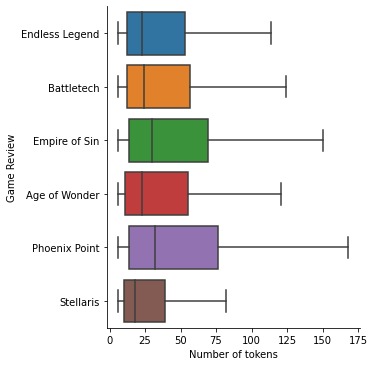

In [ ]:
sns.catplot(y="Game Review", x="Length", data=reviews_length_df, kind='box', sym="")#whis=[0, 100])
plt.xlabel("Number of tokens")
plt.show()

In [ ]:
def token_counter(corpus):
  bow = [token for document in corpus for token in document]
  token_count = Counter(bow)

  return token_count

In [ ]:
token_count_pos1 = token_counter(bow_pos1)
token_count_pos2 = token_counter(bow_pos2)
token_count_pos3 = token_counter(bow_pos3)
token_count_pos4 = token_counter(bow_pos4)
token_count_pos5 = token_counter(bow_pos5)
token_count_pos6 = token_counter(bow_pos6)

In [ ]:
cloud = WordCloud(stopwords=cloud_stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=80)

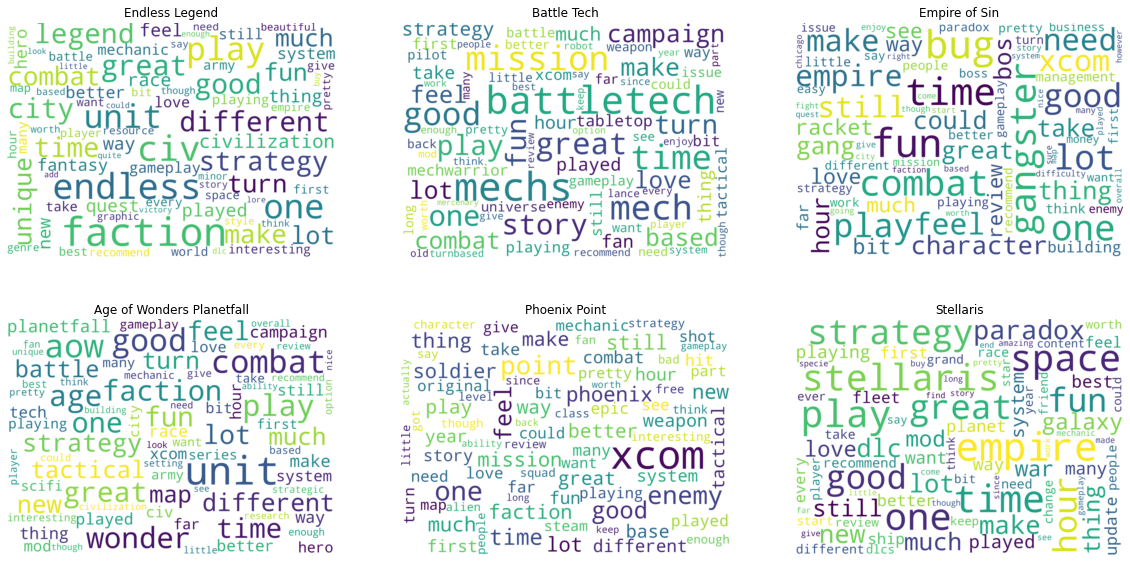

In [ ]:
fig = plt.figure(num=6, figsize=(20,10))
fig.add_subplot(2,3,1)
cloud_pos1 = cloud.generate_from_frequencies(token_count_pos1, max_font_size=300)
plt.imshow(cloud_pos1, interpolation='bilinear')
plt.axis('off')
plt.title('Endless Legend')

fig.add_subplot(2,3,2)
cloud_pos2 = cloud.generate_from_frequencies(token_count_pos2, max_font_size=300)
plt.imshow(cloud_pos2, interpolation='bilinear')
plt.axis('off')
plt.title('Battle Tech')

fig.add_subplot(2,3,3)
cloud_pos3 = cloud.generate_from_frequencies(token_count_pos3, max_font_size=300)
plt.imshow(cloud_pos3, interpolation='bilinear')
plt.axis('off')
plt.title('Empire of Sin')

fig.add_subplot(2,3,4)
cloud_pos4 = cloud.generate_from_frequencies(token_count_pos4, max_font_size=300)
plt.imshow(cloud_pos4, interpolation='bilinear')
plt.axis('off')
plt.title('Age of Wonders Planetfall')

fig.add_subplot(2,3,5)
cloud_pos5 = cloud.generate_from_frequencies(token_count_pos5, max_font_size=300)
plt.imshow(cloud_pos5, interpolation='bilinear')
plt.axis('off')
plt.title('Phoenix Point')

fig.add_subplot(2,3,6)
cloud_pos6 = cloud.generate_from_frequencies(token_count_pos6, max_font_size=300)
plt.imshow(cloud_pos6, interpolation='bilinear')
plt.axis('off')
plt.title('Stellaris')

plt.show()

In [ ]:
import networkx as nx

In [ ]:
G = nx.Graph()

In [ ]:
game_reviews_nodes = [*range(1,7)]
mentioned_games_nodes = [*range(7,12)]

In [ ]:
G.add_nodes_from(game_reviews_nodes)
G.add_nodes_from(mentioned_games_nodes)

In [ ]:
edges = [(1,7), (1,8), (1,9), (2,10), (3,10), (4,7), (4,8), (4,10), (4,11), (5,10)]

In [ ]:
G.add_edges_from(edges)

In [ ]:
labels = {}
labels[1] = "Endless Legend"
labels[2] = "Battletech"
labels[3] = "Empire of Sin"
labels[4] = "Age of Wonder"
labels[5] = "Phoenix Point"
labels[6] = "Stellaris"
labels[7] = "Civ"
labels[8] = "HoMM"
labels[9] = "Endless Space"
labels[10] = "XCOM"
labels[11] = "Alpha Centauri"

NameError: ignored

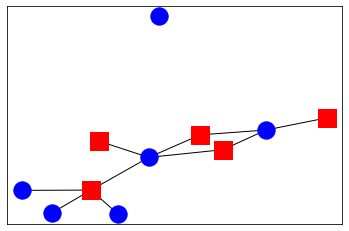

In [ ]:
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, nodelist=game_reviews_nodes, node_color='b', node_shape='o')
nx.draw_networkx_nodes(G, pos, nodelist=mentioned_games_nodes, node_color='r', node_shape='s')
nx.draw_networkx_edges(G, pos, nodelist=edges)
# nx.draw(G)
plt.savefig("game_review_network.png")

# 4. LDA Model Training

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel

In [ ]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

- Create the id2word using corpora.Dictionary()
- Create the doc-term-matrix using using the dictionary

In [ ]:
def calculate_coherence_values(dtm, id2word, corpus, start, stop, step):
    
    """
    This function does the following:
    i. creates the LDA model while increasing the number of topics;
    ii. then, it computes the coherence values for each LDA model
    """
    
    coherence_values =[]
    model_list = []
    
    for num_of_topics in range(start, stop, step):
        model = Lda(corpus=dtm, num_topics=num_of_topics, id2word=id2word,
                 chunksize=1000, passes=80, iterations=100, random_state=101)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=corpus,
                                         dictionary=id2word, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    
    return model_list, coherence_values
        

In [ ]:
# 7. Find the maximum Coherence Value, and print out the corresponding topics;
#    - discard if below 0.45, but we'll see that the 
#    - games with fewer reviews generate lower values; 
#    - in certain cases, the model with max cv is not used if the number of topics is too high

def find_maxcv_and_printtopics(ldamodel, cvmodel):
    print("Max Coherence Value :", max(cvmodel))
    for i in enumerate(cvmodel):
      print(i)
    max_cv_index = cvmodel.index(max(cvmodel))
    max_cv_topic = ldamodel[max_cv_index].show_topics(formatted=False)
    
    return max_cv_topic

### 4.1. Data pipeline and Model Optimization
- This was where I tweaked each number of topics, and also played around with the min_count, bigram threshold, trigran threshold for the create phrases function. This was when I also moved to Google Colab to use their cloud servers. I recorded  the Coherence Value for every hyperparameter change, and eventually settled on the best.

### Positive Reviews

In [ ]:
"""
Positive Review 1
The data pipeline stram is as follows:
"""

# 1. Create the preprocessed texts for bigram/trigram model
data_pos1 = preprocessor_for_phrases(pos1)

# 2. Generate the phrases, i.e. bigram/trigram
bigram_pos1, trigram_pos1 = create_phrases(data_pos1, min_count=15, bi_threshold=20, tri_threshold=15)

# 3. Preprocess the texts with phrases, removing stopwords, lemmatizer, etc.
corpus_pos1 = text_processor_with_phrases(documents=data_pos1, bigrammod=bigram_pos1, trigrammod=trigram_pos1)
# 3.1. For games with few positive or negative reviews, we use the function without phrases
# corpus_pos1 = text_processor_no_phrases(documents=data_pos1)

# 4. Create the dictionary of id2word
id2word_pos1 = corpora.Dictionary(corpus_pos1)
# id2word_pos1.save('id2word_pos1.dict')
# id2word_pos1.save('id2word_pos1.dict')


# 5. Convert list of documents (corpus) into Document Term Matrix using dictionary prepared above
dtm_pos1 = [id2word_pos1.doc2bow(doc) for doc in corpus_pos1]

# 6. Save the LDA models and Coherence Values in lists
models_pos1, cv_pos1 = calculate_coherence_values(dtm_pos1,id2word_pos1,corpus_pos1,4,30,2)

# 7. Find model with max CV and print topics
find_maxcv_and_printtopics(models_pos1, cv_pos1)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Max Coherence Value : 0.4500501722988635
(0, 0.4374030830873804)
(1, 0.4500501722988635)
(2, 0.4204269512423816)
(3, 0.43022490364431787)
(4, 0.40161139405916463)
(5, 0.43350425219197813)
(6, 0.43245589249870564)
(7, 0.4142251379045903)
(8, 0.4214501443028487)
(9, 0.4293150372389816)
(10, 0.38937677009949284)
(11, 0.4155169167401335)
(12, 0.3824212271745004)


[(0,
  [('play', 0.012225131),
   ('one', 0.011980487),
   ('get', 0.011255148),
   ('time', 0.010177306),
   ('good', 0.009838216),
   ('still', 0.009405893),
   ('playing', 0.0077786),
   ('played', 0.007124025),
   ('hour', 0.006936291),
   ('turn', 0.0066381493)]),
 (1,
  [('faction', 0.018373925),
   ('play', 0.016218256),
   ('great', 0.015195569),
   ('different', 0.012694147),
   ('strategy', 0.012146487),
   ('unique', 0.011943492),
   ('good', 0.010880423),
   ('lot', 0.010625279),
   ('fun', 0.010126925),
   ('gameplay', 0.0097888345)]),
 (2,
  [('unit', 0.023601381),
   ('city', 0.01568529),
   ('faction', 0.01138482),
   ('army', 0.010109189),
   ('one', 0.008857888),
   ('hero', 0.008093446),
   ('also', 0.008041223),
   ('battle', 0.006943761),
   ('combat', 0.006910818),
   ('quest', 0.0065174843)]),
 (3,
  [('manual', 0.0066773444),
   ('throughout', 0.0062477565),
   ('reinforcement', 0.00455642),
   ('killed', 0.0044492646),
   ('sleep', 0.0036227836),
   ('extermina

In [ ]:
for i in enumerate(cv_pos1):
  print(i)

In [ ]:
# TF-IDF 
tfIdf_pos1 = gensim.models.TfidfModel(corpus=dtm_pos1, id2word=id2word_pos1)

In [ ]:
# low_value = 0.025
# dtm_pos1_tfidf = []

for i in range(0, len(dtm_pos1)):
    bow = dtm_pos1[i]
    # low_value_words = [] #reinitialize to be safe. You can skip this.
    single_words = [id for id, value in bow if value == 1]
    new_bow = [b for b in bow if b[0] not in single_words]

    #reassign        
    dtm_pos1[i] = new_bow


In [ ]:
dtm_pos1

In [ ]:
low_value = 0.025
dtm_pos1_tfidf = []

for i in range(0, len(dtm_pos1)):
    bow = dtm_pos1[i]
    # low_value_words = [] #reinitialize to be safe. You can skip this.
    low_value_words = [id for id, value in tfIdf_pos1[bow] if value < low_value]
    new_bow = [b for b in bow if b[0] not in low_value_words]

    #reassign        
    dtm_pos1[i] = new_bow


In [ ]:
new_bow
# type(dtm_pos1)

In [ ]:
len(dtm_pos1[1])

11

In [ ]:
dtm_pos1[1][0][0]

74

In [ ]:
id2word_pos1[dtm_pos1[1][0][0]]

'endless_legend'

In [ ]:
len(corpus_pos1[1])

11

In [ ]:
"""
Positive Review 2
The data pipeline stram is as follows:
"""

# 1. Create the preprocessed texts for bigram/trigram model
data_pos2 = preprocessor_for_phrases(pos2)

# 2. Generate the phrases, i.e. bigram/trigram
bigram_pos2, trigram_pos2 = create_phrases(data_pos2, min_count=20, bi_threshold=80, tri_threshold=25)

# 3. Preprocess the texts with phrases, removing stopwords, lemmatizer, etc.
corpus_pos2 = text_processor_with_phrases(documents=data_pos2, bigrammod=bigram_pos2, trigrammod=trigram_pos2)
# 3.1. For games with few positive or negative reviews, we use the function without phrases
# corpus_pos2 = text_processor_no_phrases(documents=data_pos2)

# 4. Create the dictionary of id2word
id2word_pos2 = corpora.Dictionary(corpus_pos2)

# 5. Convert list of documents (corpus) into Document Term Matrix using dictionary prepared above
dtm_pos2 = [id2word_pos2.doc2bow(doc) for doc in corpus_pos2]

# 6. Save the LDA models and Coherence Values in lists
models_pos2, cv_pos2 = calculate_coherence_values(dtm_pos2,id2word_pos2,corpus_pos2,4,35,2)

# # 7. Find model with max CV and print topics
find_maxcv_and_printtopics(models_pos2, cv_pos2)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Max Coherence Value : 0.43328370573531166
(0, 0.3806480175189124)
(1, 0.37781139587767937)
(2, 0.3811085496687196)
(3, 0.41579619657666456)
(4, 0.41237117954871855)
(5, 0.43328370573531166)
(6, 0.40835937945721307)
(7, 0.42086976694758094)
(8, 0.3875556013655201)
(9, 0.4006353214554222)
(10, 0.41093211185098205)
(11, 0.41121055746161983)
(12, 0.3992184118599993)
(13, 0.3823647607299536)
(14, 0.3634582619142366)
(15, 0.3558816445786053)


[(5,
  [('crashing', 0.02138392),
   ('giant', 0.019143092),
   ('paper', 0.015938422),
   ('genre', 0.012728344),
   ('user', 0.012683552),
   ('robot', 0.012071456),
   ('recommended', 0.009329845),
   ('pen', 0.007095303),
   ('im_loving', 0.0068093906),
   ('winning', 0.00637663)]),
 (0,
  [('good', 0.017925937),
   ('issue', 0.01371037),
   ('play', 0.012231577),
   ('hour', 0.012177764),
   ('get', 0.011021807),
   ('review', 0.010833225),
   ('thing', 0.010766746),
   ('first', 0.010371851),
   ('time', 0.010190433),
   ('bug', 0.008370762)]),
 (4,
  [('account', 0.014876043),
   ('itch', 0.012486796),
   ('backed', 0.012112072),
   ('scratch', 0.010205568),
   ('lore', 0.009681299),
   ('region', 0.008256313),
   ('interested', 0.007941799),
   ('kickstarter', 0.006811853),
   ('gameplay', 0.006795594),
   ('robot', 0.0064446097)]),
 (8,
  [('fun', 0.043800596),
   ('great', 0.041115835),
   ('good', 0.039306473),
   ('story', 0.028267791),
   ('gameplay', 0.02110517),
   ('com

In [ ]:
"""
Positive Review 3
The data pipeline stram is as follows:
"""

# 1. Create the preprocessed texts for bigram/trigram model
data_pos3 = preprocessor_for_phrases(pos3)

# 2. Generate the phrases, i.e. bigram/trigram
bigram_pos3, trigram_pos3 = create_phrases(data_pos3, min_count=5, bi_threshold=11, tri_threshold=11)

# 3. Preprocess the texts with phrases, removing stopwords, lemmatizer, etc.
corpus_pos3 = text_processor_with_phrases(documents=data_pos3, bigrammod=bigram_pos3, trigrammod=trigram_pos3)
# 3.1. For games with few positive or negative reviews, we use the function without phrases
# corpus_pos3 = text_processor_no_phrases(documents=data_pos3)

# 4. Create the dictionary of id2word
id2word_pos3 = corpora.Dictionary(corpus_pos3)

# 5. Convert list of documents (corpus) into Document Term Matrix using dictionary prepared above
dtm_pos3 = [id2word_pos3.doc2bow(doc) for doc in corpus_pos3]

# # 6. Save the LDA models and Coherence Values in lists
models_pos3, cv_pos3 = calculate_coherence_values(dtm_pos3,id2word_pos3,corpus_pos3,2,30,2)

# # 7. Find model with max CV and print topics
find_maxcv_and_printtopics(models_pos3, cv_pos3)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Max Coherence Value : 0.296247434901781
(0, 0.28423536133581284)
(1, 0.2934519308798279)
(2, 0.2906182841006782)
(3, 0.276197421115232)
(4, 0.285165514162775)
(5, 0.296247434901781)
(6, 0.29371686751817266)
(7, 0.2839018596746312)
(8, 0.27480702980831395)
(9, 0.27582041950669933)
(10, 0.2658217355032777)
(11, 0.26477694127539636)
(12, 0.2723785885078491)
(13, 0.2656213677786155)


[(4,
  [('gang', 0.008452059),
   ('bug', 0.007962689),
   ('make', 0.0058352742),
   ('character', 0.0057624737),
   ('enemy', 0.0057530003),
   ('play', 0.005035569),
   ('gameplay', 0.0049879504),
   ('keep', 0.0049718204),
   ('fun', 0.0048892433),
   ('if_you', 0.004853728)]),
 (6,
  [('this_game', 0.0147451935),
   ('one', 0.01109859),
   ('still', 0.010085213),
   ('so_far', 0.008341247),
   ('thing', 0.0072029326),
   ('need', 0.0066127907),
   ('play', 0.0064815423),
   ('bug', 0.0056381007),
   ('fun', 0.005632386),
   ('love', 0.0054626553)]),
 (5,
  [('this_game', 0.007851616),
   ('get', 0.00678405),
   ('make', 0.005500116),
   ('one', 0.005441746),
   ('play', 0.0053576),
   ('bos', 0.0045397663),
   ('fun', 0.004508231),
   ('time', 0.0044079237),
   ('option', 0.004385474),
   ('gang', 0.004360445)]),
 (11,
  [('this_game', 0.008269445),
   ('fun', 0.0077303075),
   ('gangster', 0.007312322),
   ('combat', 0.0067184526),
   ('one', 0.0065027834),
   ('you_can', 0.00599

In [ ]:
tfIdf_pos3 = gensim.models.TfidfModel(corpus=dtm_pos3)

In [ ]:
corpuspos3_tfidf = tfIdf_pos3[dtm_pos3]
for doc in corpuspos3_tfidf:
  print(doc)

In [ ]:
tfIdf_pos3[dtm_pos3[3]]

In [ ]:
# tfidf = TfidfModel(corpus, id2word=dictionary)

low_value = 0.02
low_value_words = []
for bow in dtm_pos3:
    low_value_words += [id for id, value in tfIdf_pos3[bow] if value < low_value]

In [ ]:
for id in low_value_words:
  print(id2word_pos3[id])

In [ ]:
single_count_ids = []

for sublist in dtm_pos3:
  for token in sublist:
    # print(token)
    for id in token:
      single_count_ids.append(id)
      # print(id)
      # if str(id[1]) == '1':
    #     single_count_ids.append(id[1])

In [ ]:
id_count_pos3 = {}
for id in single_count_ids[0::2]:
  if str(id) in id_count_pos3.keys():
    id_count_pos3[str(id)] += 1
  else:
    id_count_pos3[str(id)] = 1

In [ ]:
id_count_pos3

In [ ]:
# id with max value
max(id_count_pos3, key=id_count_pos3.get)

'42'

In [ ]:
id2word_pos3[5507]

'turnbasedthis'

In [ ]:
find_maxcv_and_printtopics(models_pos3, cv_pos3)

Max Coherence Value : 0.33900009864404373


[(0,
  [('like', 0.019462712),
   ('fun', 0.0114545105),
   ('gangster', 0.009812602),
   ('time', 0.00937451),
   ('lot', 0.008440012),
   ('xcom', 0.008263151),
   ('combat', 0.008255663),
   ('get', 0.007698809),
   ('bug', 0.006553846),
   ('make', 0.0063790926)]),
 (1,
  [('like', 0.01352649),
   ('bug', 0.0092815105),
   ('get', 0.009208318),
   ('fun', 0.008508074),
   ('one', 0.0084849605),
   ('combat', 0.00789598),
   ('play', 0.006217942),
   ('time', 0.006159794),
   ('gang', 0.006006933),
   ('gangster', 0.0059824833)]),
 (2,
  [('good', 0.009487482),
   ('combat', 0.008518317),
   ('bug', 0.00843158),
   ('hour', 0.007596714),
   ('review', 0.006891451),
   ('time', 0.006616085),
   ('fun', 0.006557232),
   ('one', 0.005520638),
   ('like', 0.005398551),
   ('management', 0.0053027864)]),
 (3,
  [('like', 0.008137855),
   ('time', 0.0073655355),
   ('bug', 0.0072679394),
   ('play', 0.0060485555),
   ('need', 0.005827628),
   ('lot', 0.005720971),
   ('good', 0.005667545)

In [ ]:
"""
Positive Review 4
The data pipeline stram is as follows:
"""

# 1. Create the preprocessed texts for bigram/trigram model
data_pos4 = preprocessor_for_phrases(pos4)

# 2. Generate the phrases, i.e. bigram/trigram
bigram_pos4, trigram_pos4 = create_phrases(data_pos4, min_count=15, bi_threshold=15, tri_threshold=15)

# 3. Preprocess the texts with phrases, removing stopwords, lemmatizer, etc.
corpus_pos4 = text_processor_with_phrases(documents=data_pos4, bigrammod=bigram_pos4, trigrammod=trigram_pos4)
# 3.1. For games with few positive or negative reviews, we use the function without phrases
# corpus_pos4 = text_processor_no_phrases(documents=data_pos4)

# 4. Create the dictionary of id2word
id2word_pos4 = corpora.Dictionary(corpus_pos4)

# 5. Convert list of documents (corpus) into Document Term Matrix using dictionary prepared above
dtm_pos4 = [id2word_pos4.doc2bow(doc) for doc in corpus_pos4]

# 6. Save the LDA models and Coherence Values in lists
models_pos4, cv_pos4 = calculate_coherence_values(dtm_pos4,id2word_pos4,corpus_pos4,4,36,2)

# 7. Find model with max CV and print topics
find_maxcv_and_printtopics(models_pos4, cv_pos4)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Max Coherence Value : 0.4235583466833818
(0, 0.3541220622825878)
(1, 0.37041684276868375)
(2, 0.40277494298397326)
(3, 0.4167417899427074)
(4, 0.3807444690733576)
(5, 0.35607634471109595)
(6, 0.3781971694898082)
(7, 0.4235583466833818)
(8, 0.3950417596132602)
(9, 0.3775071577259284)
(10, 0.3450536009378467)
(11, 0.36732995455041906)
(12, 0.35535394617914406)
(13, 0.375497147337162)
(14, 0.34978243978985013)
(15, 0.346143192568682)


[(7,
  [('aow', 0.01933231),
   ('great', 0.009948007),
   ('release', 0.008979405),
   ('play', 0.008830913),
   ('good', 0.00842864),
   ('time', 0.0064288583),
   ('so_far', 0.0061905864),
   ('triumph', 0.005519138),
   ('faction', 0.0055120275),
   ('way', 0.005496722)]),
 (13,
  [('good', 0.019063348),
   ('race', 0.013683455),
   ('fun', 0.009547838),
   ('love', 0.009182189),
   ('dlc', 0.0088384),
   ('get', 0.008761906),
   ('make', 0.008292916),
   ('new', 0.008030296),
   ('thing', 0.0077146334),
   ('one', 0.0072565135)]),
 (14,
  [('aow', 0.019736577),
   ('play', 0.015345158),
   ('one', 0.013397861),
   ('age_of_wonders', 0.012813233),
   ('time', 0.011241264),
   ('great', 0.010456313),
   ('good', 0.010279316),
   ('played', 0.009137509),
   ('fun', 0.0089276675),
   ('new', 0.008779871)]),
 (12,
  [('issue', 0.010353501),
   ('lock', 0.008343982),
   ('technical_issues', 0.007478033),
   ('cursor', 0.00696049),
   ('locked', 0.006094542),
   ('reminds_me', 0.00608419

In [ ]:
"""
Positive Review 5
The data pipeline stram is as follows:
"""

# 1. Create the preprocessed texts for bigram/trigram model
data_pos5 = preprocessor_for_phrases(pos5)

# 2. Generate the phrases, i.e. bigram/trigram
# bigram_pos5, trigram_pos5 = create_phrases(data_pos5, min_count=15, bi_threshold=35, tri_threshold=10)

# 3. Preprocess the texts with phrases, removing stopwords, lemmatizer, etc.
# corpus_pos5 = text_processor_with_phrases(documents=data_pos5, bigrammod=bigram_pos5, trigrammod=trigram_pos5)
# 3.1. For games with few positive or negative reviews, we use the function without phrases
corpus_pos5 = text_processor_no_phrases(documents=data_pos5)

# 4. Create the dictionary of id2word
id2word_pos5 = corpora.Dictionary(corpus_pos5)

# # 5. Convert list of documents (corpus) into Document Term Matrix using dictionary prepared above
dtm_pos5 = [id2word_pos5.doc2bow(doc) for doc in corpus_pos5]

# # 6. Save the LDA models and Coherence Values in lists
models_pos5, cv_pos5 = calculate_coherence_values(dtm_pos5,id2word_pos5,corpus_pos5,1,30,2)

# # # 7. Find model with max CV and print topics
find_maxcv_and_printtopics(models_pos5, cv_pos5)

Max Coherence Value : 0.3511323103888529
(0, 0.3085870818847751)
(1, 0.3294626691762616)
(2, 0.3511323103888529)
(3, 0.3170591105096093)
(4, 0.3317181980682742)
(5, 0.31674376921061553)
(6, 0.29128124707972036)
(7, 0.30230564848129304)
(8, 0.30851821559737697)
(9, 0.2996749459379715)
(10, 0.29434254430235757)
(11, 0.293293627067142)
(12, 0.2869753071885748)
(13, 0.2833615166290975)
(14, 0.3127656984409018)


[(0,
  [('xcom', 0.016563771),
   ('enemy', 0.008119128),
   ('feel', 0.007873575),
   ('point', 0.0070897164),
   ('phoenix', 0.0054134685),
   ('system', 0.0049520982),
   ('lot', 0.004917629),
   ('way', 0.0045982297),
   ('make', 0.0043724184),
   ('could', 0.004326235)]),
 (1,
  [('get', 0.010790315),
   ('one', 0.010065865),
   ('enemy', 0.009484168),
   ('soldier', 0.008190771),
   ('mission', 0.008033398),
   ('point', 0.008011344),
   ('faction', 0.007259103),
   ('weapon', 0.006587671),
   ('feel', 0.006370842),
   ('base', 0.0058516525)]),
 (2,
  [('phoenix', 0.002657808),
   ('ability', 0.0024730347),
   ('ship', 0.002186559),
   ('graphic', 0.0021193859),
   ('major', 0.0020394113),
   ('reboot', 0.0017301047),
   ('whether', 0.0017138112),
   ('least', 0.0016934705),
   ('amount', 0.0016602024),
   ('monster', 0.0016007432)]),
 (3,
  [('xcom', 0.038543098),
   ('good', 0.009855415),
   ('one', 0.008899497),
   ('play', 0.007166349),
   ('point', 0.0068585863),
   ('year',

In [ ]:
"""
Positive Review 6
The data pipeline stram is as follows:
"""

# 1. Create the preprocessed texts for bigram/trigram model
data_pos6 = preprocessor_for_phrases(pos6)

# 2. Generate the phrases, i.e. bigram/trigram
bigram_pos6, trigram_pos6 = create_phrases(data_pos6, min_count=20, bi_threshold=35, tri_threshold=25)

# 3. Preprocess the texts with phrases, removing stopwords, lemmatizer, etc.
corpus_pos6 = text_processor_with_phrases(documents=data_pos6, bigrammod=bigram_pos6, trigrammod=trigram_pos6)
# 3.1. For games with few positive or negative reviews, we use the function without phrases
# corpus_pos6 = text_processor_no_phrases(documents=data_pos6)

# 4. Create the dictionary of id2word
id2word_pos6 = corpora.Dictionary(corpus_pos6)

# 5. Convert list of documents (corpus) into Document Term Matrix using dictionary prepared above
dtm_pos6 = [id2word_pos6.doc2bow(doc) for doc in corpus_pos6]

# 6. Save the LDA models and Coherence Values in lists
models_pos6, cv_pos6 = calculate_coherence_values(dtm_pos6,id2word_pos6,corpus_pos6,4,30,2)

# 7. Find model with max CV and print topics
find_maxcv_and_printtopics(models_pos6, cv_pos6)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Max Coherence Value : 0.44322373890842126
(0, 0.4141465804570626)
(1, 0.44322373890842126)
(2, 0.42361004563835836)
(3, 0.43671125853830406)
(4, 0.37550755460354535)
(5, 0.3996934846369851)
(6, 0.3694122188632039)
(7, 0.3894859860702663)
(8, 0.363275004297023)
(9, 0.37729617679873806)
(10, 0.39923572491521764)
(11, 0.3655540646229024)
(12, 0.3720256441767355)


[(0,
  [('space', 0.019480681),
   ('time', 0.0151781),
   ('stellaris', 0.014254638),
   ('play', 0.014138079),
   ('one', 0.013498089),
   ('strategy', 0.01282018),
   ('great', 0.012569087),
   ('get', 0.010522306),
   ('fun', 0.010250624),
   ('hour', 0.008931805)]),
 (1,
  [('paradox', 0.020210782),
   ('update', 0.019199127),
   ('new', 0.018117018),
   ('stellaris', 0.016915768),
   ('still', 0.0140296705),
   ('change', 0.013745333),
   ('better', 0.012255758),
   ('patch', 0.010323453),
   ('issue', 0.00961424),
   ('year', 0.008624061)]),
 (2,
  [('empire', 0.018375237),
   ('fleet', 0.015602803),
   ('planet', 0.014708251),
   ('system', 0.014501734),
   ('ship', 0.012753029),
   ('war', 0.012265973),
   ('make', 0.007748968),
   ('research', 0.00723897),
   ('race', 0.0060168765),
   ('build', 0.0058787586)]),
 (3,
  [('time', 0.024573697),
   ('hour', 0.022305802),
   ('get', 0.013689916),
   ('first', 0.013531791),
   ('day', 0.012094737),
   ('one', 0.011946172),
   ('go

### Negative Reviews

In [ ]:
"""
Negative Review 1
The data pipeline stram is as follows:
"""

# 1. Create the preprocessed texts for bigram/trigram model
data_neg1 = preprocessor_for_phrases(neg1)

# 2. Generate the phrases, i.e. bigram/trigram
bigram_neg1, trigram_neg1 = create_phrases(data_neg1, min_count=20, bi_threshold=20, tri_threshold=15)

# 3. Preprocess the texts with phrases, removing stopwords, lemmatizer, etc.
corpus_neg1 = text_processor_with_phrases(documents=data_neg1, bigrammod=bigram_neg1, trigrammod=trigram_neg1)
# 3.1. For games with few positive or negative reviews, we use the function without phrases
# corpus_neg1 = text_processor_no_phrases(documents=data_neg1)

# 4. Create the dictionary of id2word
id2word_neg1 = corpora.Dictionary(corpus_neg1)

# 5. Convert list of documents (corpus) into Document Term Matrix using dictionary prepared above
dtm_neg1 = [id2word_neg1.doc2bow(doc) for doc in corpus_neg1]

# 6. Save the LDA models and Coherence Values in lists
models_neg1, cv_neg1 = calculate_coherence_values(dtm_neg1,id2word_neg1,corpus_neg1,4,20,2)

# 7. Find model with max CV and print topics
find_maxcv_and_printtopics(models_neg1, cv_neg1)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Max Coherence Value : 0.32491151404704566
(0, 0.2900625583940429)
(1, 0.2812332069609554)
(2, 0.2972562527774276)
(3, 0.2820638583615608)
(4, 0.32491151404704566)
(5, 0.3080209523306802)
(6, 0.30793008340636396)
(7, 0.3046600784432807)


[(3,
  [('endless_space', 0.016597781),
   ('hero', 0.009017281),
   ('cost', 0.0074141566),
   ('also', 0.0073686116),
   ('get', 0.0072605517),
   ('civ', 0.006779025),
   ('one', 0.006770083),
   ('would', 0.0063786465),
   ('boring', 0.0060682585),
   ('look', 0.0060284943)]),
 (2,
  [('endless_legend', 0.012620194),
   ('problem', 0.0077687674),
   ('intel', 0.007760293),
   ('unit', 0.0068575246),
   ('yet', 0.0067078047),
   ('purchased', 0.00670711),
   ('combat', 0.0064922418),
   ('plan', 0.0059136497),
   ('civilisation', 0.0055897078),
   ('everytime', 0.0055321283)]),
 (1,
  [('time', 0.013530194),
   ('great', 0.013375729),
   ('good', 0.008332892),
   ('play', 0.008073292),
   ('many', 0.0076613678),
   ('back', 0.007319088),
   ('bad', 0.0068390267),
   ('save', 0.006582028),
   ('review', 0.006474473),
   ('problem', 0.006474138)]),
 (4,
  [('looking', 0.01347045),
   ('challenge', 0.013135089),
   ('playing', 0.010782788),
   ('boring', 0.009478148),
   ('pretty', 0.0

In [ ]:
"""
Negative Review 2
The data pipeline stram is as follows:
"""

# 1. Create the preprocessed texts for bigram/trigram model
data_neg2 = preprocessor_for_phrases(neg2)

# 2. Generate the phrases, i.e. bigram/trigram
bigram_neg2, trigram_neg2 = create_phrases(data_neg2, min_count=15, bi_threshold=35, tri_threshold=10)

# 3. Preprocess the texts with phrases, removing stopwords, lemmatizer, etc.
corpus_neg2 = text_processor_with_phrases(documents=data_neg2, bigrammod=bigram_neg2, trigrammod=trigram_neg2)
# 3.1. For games with few positive or negative reviews, we use the function without phrases
# corpus_neg2 = text_processor_no_phrases(documents=data_neg2)

# 4. Create the dictionary of id2word
id2word_neg2 = corpora.Dictionary(corpus_neg2)

# 5. Convert list of documents (corpus) into Document Term Matrix using dictionary prepared above
dtm_neg2 = [id2word_neg2.doc2bow(doc) for doc in corpus_neg2]

# 6. Save the LDA models and Coherence Values in lists
models_neg2, cv_neg2 = calculate_coherence_values(dtm_neg2,id2word_neg2,corpus_neg2,6,40,2)

# 7. Find model with max CV and print topics
find_maxcv_and_printtopics(models_neg2, cv_neg2)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Max Coherence Value : 0.5064335453606439
(0, 0.3473413108081301)
(1, 0.5064335453606439)
(2, 0.45282963582879354)
(3, 0.42797336588287643)
(4, 0.42904119897213083)
(5, 0.4082404022071196)
(6, 0.4576193174293269)
(7, 0.4650198257724371)
(8, 0.43677288976638096)
(9, 0.43177999279601736)
(10, 0.43830795925574)
(11, 0.43451190139416285)
(12, 0.3981880022406844)
(13, 0.4165886716077293)
(14, 0.40272102716153)
(15, 0.39447996298108173)
(16, 0.4105017029027375)


[(0,
  [('mechs', 0.01691631),
   ('mission', 0.014076052),
   ('mech', 0.012888938),
   ('get', 0.010458414),
   ('one', 0.009186227),
   ('time', 0.007897357),
   ('enemy', 0.0071552857),
   ('make', 0.0054000476),
   ('take', 0.0052675675),
   ('story', 0.0048306817)]),
 (1,
  [('limitation', 0.0036094536),
   ('promise', 0.003202132),
   ('require', 0.00281283),
   ('expansion', 0.0028092088),
   ('lack', 0.0026658867),
   ('rip', 0.0026412415),
   ('we_got', 0.002466065),
   ('gets_old', 0.0024465236),
   ('dated', 0.0023554375),
   ('kickstarter', 0.002303696)]),
 (2,
  [('people', 0.0058804387),
   ('sjw', 0.0043650214),
   ('politics', 0.0042338255),
   ('company', 0.003995255),
   ('princess', 0.0037717994),
   ('fck_that', 0.0036153756),
   ('multiplayer', 0.00338266),
   ('battletech', 0.0033188588),
   ('already', 0.0031296643),
   ('support', 0.00293425)]),
 (3,
  [('exceed', 0.0034255146),
   ('chug', 0.0031440454),
   ('mac', 0.0030274368),
   ('realy', 0.0027751154),
  

In [ ]:
"""
Negative Review 3
The data pipeline stram is as follows:
"""

# 1. Create the preprocessed texts for bigram/trigram model
data_neg3 = preprocessor_for_phrases(neg3)

# 2. Generate the phrases, i.e. bigram/trigram
bigram_neg3, trigram_neg3 = create_phrases(data_neg3, min_count=15, bi_threshold=35, tri_threshold=10)

# 3. Preprocess the texts with phrases, removing stopwords, lemmatizer, etc.
# corpus_neg3 = text_processor_with_phrases(documents=data_neg3, bigrammod=bigram_neg3, trigrammod=trigram_neg3)
# 3.1. For games with few positive or negative reviews, we use the function without phrases
corpus_neg3 = text_processor_no_phrases(documents=data_neg3)

# 4. Create the dictionary of id2word
id2word_neg3 = corpora.Dictionary(corpus_neg3)

# 5. Convert list of documents (corpus) into Document Term Matrix using dictionary prepared above
dtm_neg3 = [id2word_neg3.doc2bow(doc) for doc in corpus_neg3]

# 6. Save the LDA models and Coherence Values in lists
models_neg3, cv_neg3 = calculate_coherence_values(dtm_neg3,id2word_neg3,corpus_neg3,1,30,2)

# 7. Find model with max CV and print topics
find_maxcv_and_printtopics(models_neg3, cv_neg3)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Max Coherence Value : 0.31134363121606806


[(0,
  [('combat', 0.010361063),
   ('get', 0.008743707),
   ('one', 0.008039664),
   ('time', 0.0074014124),
   ('make', 0.006691352),
   ('feel', 0.006245016),
   ('character', 0.005957453),
   ('gangster', 0.005772586),
   ('building', 0.0053910296),
   ('bos', 0.0051741246)]),
 (1,
  [('bug', 0.019958694),
   ('time', 0.0071548964),
   ('many', 0.0063328235),
   ('get', 0.005915702),
   ('would', 0.0056351023),
   ('fix', 0.004935363),
   ('hour', 0.0047680456),
   ('play', 0.0046050125),
   ('still', 0.004569817),
   ('review', 0.0045015267)]),
 (2,
  [('hour', 0.0073660333),
   ('paradox', 0.0073216488),
   ('get', 0.0067990855),
   ('worth', 0.0047047967),
   ('buy', 0.0042490866),
   ('right', 0.004075408),
   ('could', 0.0039324122),
   ('refund', 0.003808436),
   ('bug', 0.0037953677),
   ('good', 0.0035167604)])]

In [ ]:
"""
Negative Review 4
The data pipeline stram is as follows:
"""

# 1. Create the preprocessed texts for bigram/trigram model
data_neg4 = preprocessor_for_phrases(neg4)

# 2. Generate the phrases, i.e. bigram/trigram
bigram_neg4, trigram_neg4 = create_phrases(data_neg4, min_count=15, bi_threshold=35, tri_threshold=10)

# 3. Preprocess the texts with phrases, removing stopwords, lemmatizer, etc.
corpus_neg4 = text_processor_with_phrases(documents=data_neg4, bigrammod=bigram_neg4, trigrammod=trigram_neg4)
# 3.1. For games with few positive or negative reviews, we use the function without phrases
# corpus_neg4 = text_processor_no_phrases(documents=data_neg4)

# 4. Create the dictionary of id2word
id2word_neg4 = corpora.Dictionary(corpus_neg4)

# 5. Convert list of documents (corpus) into Document Term Matrix using dictionary prepared above
dtm_neg4 = [id2word_neg4.doc2bow(doc) for doc in corpus_neg4]

# 6. Save the LDA models and Coherence Values in lists
models_neg4, cv_neg4 = calculate_coherence_values(dtm_neg4,id2word_neg4,corpus_neg4,6,40,2)

# 7. Find model with max CV and print topics
find_maxcv_and_printtopics(models_neg4, cv_neg4)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Max Coherence Value : 0.27817207156889123
(0, 0.272620292912053)
(1, 0.25679957635371425)
(2, 0.2571538197409255)
(3, 0.26879678738507257)
(4, 0.2620814701281932)
(5, 0.263506823754122)
(6, 0.27097089517127854)
(7, 0.2708862575971436)
(8, 0.2597282340601414)
(9, 0.27401307057666496)
(10, 0.2750618723655776)
(11, 0.2757466903947545)
(12, 0.26330930085391513)
(13, 0.27803169049235477)
(14, 0.27215826018828754)
(15, 0.27817207156889123)
(16, 0.27604619477930153)


[(29,
  [('unit', 0.014709339),
   ('one', 0.011096782),
   ('this_game', 0.01082079),
   ('get', 0.00946538),
   ('problem', 0.008339598),
   ('city', 0.007837285),
   ('new', 0.006975121),
   ('look', 0.0065690563),
   ('good', 0.0062786313),
   ('aow', 0.005869573)]),
 (11,
  [('three', 0.013280674),
   ('problem', 0.010690023),
   ('turn', 0.010639221),
   ('boring', 0.0106392205),
   ('check', 0.0106392205),
   ('this_game', 0.009953907),
   ('crashed', 0.009512592),
   ('reloaded', 0.007997759),
   ('much', 0.007997759),
   ('better', 0.007997759)]),
 (24,
  [('aow', 0.028244916),
   ('unit', 0.015586602),
   ('faction', 0.011225783),
   ('the_same', 0.010309468),
   ('get', 0.00909123),
   ('age_of', 0.008886146),
   ('make', 0.008672255),
   ('wonder', 0.007859284),
   ('boring', 0.00717297),
   ('play', 0.0067669596)]),
 (30,
  [('this_game', 0.0137056),
   ('a_lot', 0.008600431),
   ('time', 0.008208136),
   ('one', 0.007733996),
   ('thing', 0.0071351146),
   ('age_of', 0.00

In [ ]:
"""
Negative Review 5
The data pipeline stram is as follows:
"""

# 1. Create the preprocessed texts for bigram/trigram model
data_neg5 = preprocessor_for_phrases(neg5)

# 2. Generate the phrases, i.e. bigram/trigram
bigram_neg5, trigram_neg5 = create_phrases(data_neg5, min_count=5, bi_threshold=35, tri_threshold=35)

# 3. Preprocess the texts with phrases, removing stopwords, lemmatizer, etc.
corpus_neg5 = text_processor_with_phrases(documents=data_neg5, bigrammod=bigram_neg5, trigrammod=trigram_neg5)
# 3.1. For games with few positive or negative reviews, we use the function without phrases
# corpus_neg5 = text_processor_no_phrases(documents=data_neg5)

# 4. Create the dictionary of id2word
id2word_neg5 = corpora.Dictionary(corpus_neg5)

# 5. Convert list of documents (corpus) into Document Term Matrix using dictionary prepared above
dtm_neg5 = [id2word_neg5.doc2bow(doc) for doc in corpus_neg5]

# 6. Save the LDA models and Coherence Values in lists
models_neg5, cv_neg5 = calculate_coherence_values(dtm_neg5,id2word_neg5,corpus_neg5,2,30,2)

# 7. Find model with max CV and print topics
find_maxcv_and_printtopics(models_neg5, cv_neg5)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Max Coherence Value : 0.29840299903555956
(0, 0.29840299903555956)
(1, 0.2600666444497785)
(2, 0.25181812934952125)
(3, 0.2739474039181976)
(4, 0.284059294980172)
(5, 0.26480548830836753)
(6, 0.2686538166956514)
(7, 0.2883517286354592)
(8, 0.26672485515144373)
(9, 0.2681003583524294)
(10, 0.27463392359336747)
(11, 0.2858478547003013)
(12, 0.2684442374660453)
(13, 0.2931015469499852)


[(0,
  [('xcom', 0.0137840975),
   ('enemy', 0.010716578),
   ('get', 0.009046112),
   ('one', 0.007833097),
   ('mission', 0.0077539757),
   ('time', 0.0071546393),
   ('make', 0.0060142977),
   ('soldier', 0.0054444703),
   ('play', 0.005407879),
   ('feel', 0.004823151)]),
 (1,
  [('xcom', 0.005464699),
   ('controller', 0.003443948),
   ('phoenix_point', 0.0025373779),
   ('made', 0.0024937612),
   ('work', 0.0020520792),
   ('year', 0.002007897),
   ('review', 0.0018830845),
   ('steam', 0.0018497125),
   ('bad', 0.0017042268),
   ('great', 0.0016961921)])]

In [ ]:
"""
Negative Review 6
The data pipeline stram is as follows:
"""

# 1. Create the preprocessed texts for bigram/trigram model
data_neg6 = preprocessor_for_phrases(neg6)

# 2. Generate the phrases, i.e. bigram/trigram
bigram_neg6, trigram_neg6 = create_phrases(data_neg6, min_count=15, bi_threshold=25, tri_threshold=15)

# 3. Preprocess the texts with phrases, removing stopwords, lemmatizer, etc.
corpus_neg6 = text_processor_with_phrases(documents=data_neg6, bigrammod=bigram_neg6, trigrammod=trigram_neg6)
# 3.1. For games with few positive or negative reviews, we use the function without phrases
# corpus_neg6 = text_processor_no_phrases(documents=data_neg6)

# 4. Create the dictionary of id2word
id2word_neg6 = corpora.Dictionary(corpus_neg6)

# 5. Convert list of documents (corpus) into Document Term Matrix using dictionary prepared above
dtm_neg6 = [id2word_neg6.doc2bow(doc) for doc in corpus_neg6]

# 6. Save the LDA models and Coherence Values in lists
models_neg6, cv_neg6 = calculate_coherence_values(dtm_neg6,id2word_neg6,corpus_neg6,4,30,2)

# 7. Find model with max CV and print topics
find_maxcv_and_printtopics(models_neg6, cv_neg6)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Max Coherence Value : 0.47922202161763394
(0, 0.35461153035293325)
(1, 0.42712196844163114)
(2, 0.44310045040851975)
(3, 0.40893583366993)
(4, 0.44435138461628987)
(5, 0.4319698526732589)
(6, 0.4418687416108579)
(7, 0.47922202161763394)
(8, 0.46393650634826067)
(9, 0.4504047233927661)
(10, 0.4696903718323118)
(11, 0.4679498870222706)
(12, 0.4425393543990594)


[(8,
  [('bonus', 0.007994317),
   ('pre', 0.0072413473),
   ('edit', 0.0068277186),
   ('range', 0.0066975225),
   ('mechanic', 0.0062252283),
   ('unit', 0.0049494496),
   ('player', 0.004858933),
   ('goal', 0.0047478573),
   ('stellaris', 0.004646777),
   ('loss', 0.004633601)]),
 (15,
  [('planet', 0.04579784),
   ('empire', 0.021820953),
   ('sector', 0.021428082),
   ('resource', 0.016870322),
   ('building', 0.0118155535),
   ('build', 0.010606563),
   ('pop', 0.010003837),
   ('war', 0.007529366),
   ('system', 0.0072740186),
   ('also', 0.0068589635)]),
 (10,
  [('buck', 0.0092952335),
   ('offering', 0.009176948),
   ('neighbour', 0.008108276),
   ('payed', 0.00801817),
   ('told', 0.00695568),
   ('fleet_capacity', 0.0064990562),
   ('rally_points', 0.005442477),
   ('gamers', 0.0049770265),
   ('disgusting', 0.0048803454),
   ('rating', 0.0048772804)]),
 (7,
  [('get', 0.0135361375),
   ('empire', 0.010705097),
   ('time', 0.009603401),
   ('make', 0.008680458),
   ('one',

In [ ]:
# id2word_pos1 = corpora.Dictionary(corpus_pos1)
# id2word_pos2 = corpora.Dictionary(corpus_pos2)
id2word_pos3 = corpora.Dictionary(corpus_pos3)
# id2word_pos4 = corpora.Dictionary(corpus_pos4)
# id2word_pos5 = corpora.Dictionary(corpus_pos5)
# id2word_pos6 = corpora.Dictionary(corpus_pos6)

In [ ]:
id2word_neg1 = corpora.Dictionary(corpus_neg1)
id2word_neg2 = corpora.Dictionary(corpus_neg2)
id2word_neg3 = corpora.Dictionary(corpus_neg3)
id2word_neg4 = corpora.Dictionary(corpus_neg4)
id2word_neg5 = corpora.Dictionary(corpus_neg5)
id2word_neg6 = corpora.Dictionary(corpus_neg6)

In [ ]:
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
# dtm_pos1 = [id2word_pos1.doc2bow(doc) for doc in corpus_pos1]
# dtm_pos2 = [id2word_pos2.doc2bow(doc) for doc in corpus_pos2]
dtm_pos3 = [id2word_pos3.doc2bow(doc) for doc in corpus_pos3]
# dtm_pos4 = [id2word_pos4.doc2bow(doc) for doc in corpus_pos4]
# dtm_pos5 = [id2word_pos5.doc2bow(doc) for doc in corpus_pos5]
# dtm_pos6 = [id2word_pos6.doc2bow(doc) for doc in corpus_pos6]

In [ ]:
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
dtm_neg1 = [id2word_neg1.doc2bow(doc) for doc in corpus_neg1]
dtm_neg2 = [id2word_neg2.doc2bow(doc) for doc in corpus_neg2]
dtm_neg3 = [id2word_neg3.doc2bow(doc) for doc in corpus_neg3]
dtm_neg4 = [id2word_neg4.doc2bow(doc) for doc in corpus_neg4]
dtm_neg5 = [id2word_neg5.doc2bow(doc) for doc in corpus_neg5]
dtm_neg6 = [id2word_neg6.doc2bow(doc) for doc in corpus_neg6]

In [ ]:
models_pos1, cv_pos1 = calculate_coherence_values(dtm_pos1,id2word_pos1,corpus_pos1,2,30,3)

In [ ]:
# change the parameters below
#min_count=15, bi_threshold=35, tri_threshold=12
for i in enumerate(cv_pos1):
    print(i)

In [ ]:
#min_count=10, bigram=35, trigram=10
for i in enumerate(cv_pos1):
    print(i)

In [ ]:
models_pos1[5].print_topics()

In [ ]:
#bigram 28
for i in enumerate(cv_pos1):
    print(i)

In [ ]:
for i in enumerate(cv_pos1):
    print(i)

In [ ]:
for i in enumerate(cv_pos1):
    print(i)

In [ ]:
# this is with bigram threshold = 30
for i in enumerate(cv_pos1):
    print(i)

In [ ]:
models_pos1[2].print_topics()

In [ ]:
models_pos1[2].print_topics()

In [ ]:
models_pos2, cv_pos2 = calculate_coherence_values(dtm_pos2,id2word_pos2,corpus_pos2,2,35,3)

In [ ]:
print(max(cv_pos2))

In [ ]:
for i in enumerate(cv_pos2):
    print(i)

In [ ]:
models_pos2[6].print_topics()

In [ ]:
models_pos3, cv_pos3 = calculate_coherence_values(dtm_pos3,id2word_pos3,corpus_pos3,2,30,3)

In [ ]:
print(max(cv_pos3))

In [ ]:
for i in enumerate(cv_pos3):
    print(i)

In [ ]:
models_pos3[0].print_topics()

In [ ]:
models_pos4, cv_pos4 = calculate_coherence_values(dtm_pos4,id2word_pos4,corpus_pos4,2,30,3)

In [ ]:
for i in enumerate(cv_pos4):
    print(i)

In [ ]:
models_pos4[4].print_topics()

In [ ]:
models_pos5, cv_pos5 = calculate_coherence_values(dtm_pos5,id2word_pos5,corpus_pos5,2,35,3)

In [ ]:
for i in enumerate(cv_pos5):
    print(i)

In [ ]:
models_pos5[2].print_topics()

In [ ]:
models_pos6, cv_pos6 = calculate_coherence_values(dtm_pos6,id2word_pos6,corpus_pos6,2,40,3)

In [ ]:
for i in enumerate(cv_pos6):
    print(i)

In [ ]:
models_pos6[1].print_topics()

In [ ]:
# lda_pos6 = Lda(corpus=dtm_pos6, num_topics=10, id2word=id2word_pos6,
#                chunksize=1000, passes=50, iterations=80, random_state=16)
lda_neg6 = Lda(corpus=dtm_neg6, num_topics=10, id2word=id2word_neg6,
               chunksize=1000, passes=50, iterations=80, random_state=16)

In [ ]:
print(lda_neg6.print_topics())
coherence_model_neg6 = CoherenceModel(model=lda_neg6, texts=corpus6_neg,
                                      dictionary=id2word_neg6, coherence='c_v')
print(coherence_model_neg6.get_coherence())

In [ ]:
pos1['clean'] = pos1['review'].apply(lambda x: simple_preprocessor(x))
pos1['clean'] = pos1['review'].apply(lambda x: simple_preprocessor(x))



In [ ]:
pos6['clean'] = pos6['review'].apply(lambda x: simple_preprocessor(x))
pos6.head(20)

In [ ]:
data_pos6 = pos6.clean.values.tolist()

In [ ]:
# what i did previously
# data_pos1 = pos1.clean.values.tolist()
data_pos1 = pos1.clean.values.tolist()

In [ ]:
# Build the bigram and trigram models
# Train on the list of tokenized words that's only been removed of punctuations and digits
bigram = gensim.models.Phrases(data_pos1, min_count=2, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_pos1], threshold=30)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
# neg6['clean'] = neg6.review.apply(lambda x: simple_preprocessor(x))
neg6['clean2'] = neg6.clean.apply(lambda x: text_processor_with_phrases(x))
neg6
# data_neg6 = neg6.clean.values.tolist()

In [ ]:
# Build the bigram and trigram models
# Train on the list of tokenized words that's only been removed of punctuations and digits
bigram = gensim.models.Phrases(data_neg6, min_count=10, threshold=30) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_neg6], threshold=10)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
def text_processor_with_phrases(text):
    text = bigram_mod[text]
    text = trigram_mod[bigram_mod[text]]
    # Remove stopwords 
    nostopwords = [token for token in text if token not in stop_words]   
    # Lemmatize the remaining tokens
    lemmatized = [lemmatizer.lemmatize(token) for token in nostopwords]
    # Drop tokens if it has 2 or less characters
    clean_tokens = [token for token in lemmatized if len(token) > 2]
    
    return clean_tokens
    

In [ ]:
pos1['clean2'] = pos1['clean'].apply(lambda x: text_processor_with_phrases(x))

In [ ]:
pos1

In [ ]:
pos1['length'] = pos1['lemmatized'].apply(lambda x: len(x))
pos1 = pos1[pos1['length'] > 1]

In [ ]:
corpus1_pos = pos1['clean2'].values.tolist()

In [ ]:
pos6['clean2'] = pos6['clean'].apply(lambda x: text_processor_with_phrases(x))

In [ ]:
neg6['length'] = neg6['clean2'].apply(lambda x: len(x))

In [ ]:
neg6 = neg6[neg6['length'] > 3]

In [ ]:
# corpus6_pos = pos6['clean2'].values.tolist()
corpus6_neg = neg6['clean2'].values.tolist()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim import corpora

In [ ]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

In [ ]:
#id2word_pos1 = corpora.Dictionary(corpus1_pos)
# id2word_pos6 = corpora.Dictionary(corpus6_pos)
id2word_neg6 = corpora.Dictionary(corpus6_neg)


In [ ]:
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
# dtm_pos1 = [id2word_pos1.doc2bow(doc) for doc in corpus1_pos]
# dtm_pos6 = [id2word_pos6.doc2bow(doc) for doc in corpus6_pos]
dtm_neg6 = [id2word_neg6.doc2bow(doc) for doc in corpus6_neg]

In [ ]:
# lda_pos6 = Lda(corpus=dtm_pos6, num_topics=10, id2word=id2word_pos6,
#                chunksize=1000, passes=50, iterations=80, random_state=16)
lda_neg6 = Lda(corpus=dtm_neg6, num_topics=10, id2word=id2word_neg6,
               chunksize=1000, passes=50, iterations=80, random_state=16)

In [ ]:
# print(lda_pos6.print_topics())


In [ ]:
print(lda_neg6.print_topics())
coherence_model_neg6 = CoherenceModel(model=lda_neg6, texts=corpus6_neg,
                                      dictionary=id2word_neg6, coherence='c_v')
print(coherence_model_neg6.get_coherence())

In [ ]:
lda_pos1 = Lda(corpus=dtm_pos1, num_topics=5, id2word=id2word_pos1,
               chunksize=1000, passes=80, iterations=100, random_state=16)

In [ ]:
print(lda_pos1.print_topics())

In [ ]:
print(lda_pos1.print_topics())

In [ ]:
print(lda_pos1.print_topics())

In [ ]:
print(lda_pos1.print_topics())

In [ ]:
doc_lda = lda_pos1[dtm_pos1]

In [ ]:
topic_scores = [[topic_score[1] for topic_score in sent] for sent in doc_lda]

In [ ]:
max(topic_scores[2])

In [ ]:
topic_scores

In [ ]:
coherence_model_pos1 = CoherenceModel(model=lda_pos1, texts=corpus1_pos,
                                      dictionary=id2word_pos1, coherence='c_v')

In [ ]:
# varying score score
coherence_model_pos1.get_coherence()

In [ ]:
coherence_model_pos1.get_coherence()

In [ ]:
lda_pos1.log_perplexity(dtm_pos1)

In [ ]:
def calculate_coherence_values(dtm, id2word, corpus, start, stop, step):
    
    """
    Computes the coherence values while increasing the number of topics
    """
    
    coherence_values =[]
    model_list = []
    
    for num_of_topics in range(start, stop, step):
        model = Lda(corpus=dtm, num_topics=num_of_topics, id2word=id2word,
                 chunksize=1000, passes=80, iterations=100, random_state=101)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=corpus,
                                         dictionary=id2word_pos1, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    
    return model_list, coherence_values
        

In [ ]:
models_pos1, cv_pos1 = calculate_coherence_values(dtm_pos1,id2word_pos1,corpus1_pos,2,30,3)

In [ ]:
for i in enumerate(cv_pos1):
    print(i)

In [ ]:
models_pos1[2].print_topics()

In [ ]:
models_neg6, cv_neg6 = calculate_coherence_values(dtm_neg6,id2word_neg6,corpus6_neg,3,30,3)

In [ ]:
# Apply the clean processor on the positive reviewed documents
clean_pos1 = simple_preprocessor(pos1)
clean_pos2 = simple_preprocessor(pos2)
clean_pos3 = simple_preprocessor(pos3)
clean_pos4 = simple_preprocessor(pos4)
clean_pos5 = simple_preprocessor(pos5)

In [ ]:
# Apply the clean processor on the negative reviewed documents
clean_neg1 = simple_preprocessor(neg1)
clean_neg2 = simple_preprocessor(neg2)
clean_neg3 = simple_preprocessor(neg3)
clean_neg4 = simple_preprocessor(neg4)
clean_neg5 = simple_preprocessor(neg5)

In [ ]:
corpus_pos = []
corpus_pos.append(clean_pos1)
corpus_pos.append(clean_pos2)
corpus_pos.append(clean_pos3)
corpus_pos.append(clean_pos4)
corpus_pos.append(clean_pos5)

In [ ]:
len(clean_pos2)

In [ ]:
len(corpus_pos)

In [ ]:
corpus_neg = [clean_neg1, clean_neg2, clean_neg3, clean_neg4, clean_neg5]
corpus_neg

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim import corpora

In [ ]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index.
dictionary_pos = corpora.Dictionary(corpus_pos)
dictionary_neg = corpora.Dictionary(corpus_neg)

In [ ]:
print(dictionary_pos.token2id)

In [ ]:
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix_pos = [dictionary_pos.doc2bow(doc) for doc in corpus_pos]

In [ ]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(corpus=doc_term_matrix, num_topics=5, id2word = dictionary,
               chunksize=1000, passes=80, iterations=100, random_state=16)

In [ ]:
print(ldamodel.print_topics())

In [ ]:
# Import Gensim to run LDA model on corpora
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

In [ ]:
# Skip this for now
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=4, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
negative_reviews = negative_reviews.loc[:, ['review']]

In [ ]:
negative_reviews['review_clean'] = negative_reviews['review'].apply(lambda x: text_preprocessor1(x))

In [ ]:
negative_reviews['review_clean2'] = negative_reviews['review_clean'].apply(lambda x: text_preprocessor2(x))

In [ ]:
negative_reviews['tokenized'] = negative_reviews['review_clean2'].apply(lambda x: nltk.word_tokenize(x))

In [ ]:
negative_reviews.head()

In [ ]:
negative_reviews_cleaned = list(negative_reviews['tokenized'])

In [ ]:
dictionary_neg = corpora.Dictionary(negative_reviews_cleaned)

In [ ]:
doc_term_matrix_neg = [dictionary_neg.doc2bow(doc) for doc in negative_reviews_cleaned]

In [ ]:
ldamodel_neg = Lda(doc_term_matrix_neg, num_topics=5, id2word = dictionary_neg, 
                   chunksize=1000, passes=50, iterations=100, random_state=16)

In [ ]:
print(ldamodel_neg.print_topics())

# Evaluation Metrics

In [ ]:
ldamodel.log_perplexity(doc_term_matrix)

In [ ]:
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=ldamodel, text=)

# EDA

# Chart LDA

In [ ]:
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

In [ ]:
pyLDAvis.enable_notebook()